In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import numpy as np
from collections import OrderedDict

%pylab inline
rcParams["figure.figsize"] = (16,5)
sys.path.append('/home/erogol/projects/')

import librosa
import librosa.display

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config
from TTS.utils.text import text_to_sequence

import IPython
from IPython.display import Audio
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tts(model, text, CONFIG, use_cuda, ap, figures=True):
    t_1 = time.time()
    waveform, alignment, spectrogram = create_speech(model, text, CONFIG, use_cuda, ap) 
    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, spectrogram, CONFIG)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.sample_rate))  
    return alignment, spectrogram

In [3]:
# Set constants
ROOT_PATH = '../result/February-13-2018_01:04AM/'
MODEL_PATH = ROOT_PATH + '/best_model.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = ROOT_PATH + '/test/'
CONFIG = load_config(CONFIG_PATH)
use_cuda = False

In [5]:
# load the model
model = Tacotron(CONFIG.embedding_size, CONFIG.hidden_size,
                 CONFIG.num_mels, CONFIG.num_freq, CONFIG.r)

# load the audio processor
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms, CONFIG.preemphasis,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, griffin_lim_iters=80)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# # small trick to remove DataParallel wrapper
new_state_dict = OrderedDict()
for k, v in cp['model'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
cp['model'] = new_state_dict

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()

 | > Embedding dim : 149


KeyError: 'unexpected key "module.embedding.weight" in state_dict'

In [6]:
cp['model']

OrderedDict([('module.embedding.weight', 
              -3.5297e-02 -3.2110e-02  1.5772e-02  ...   1.5752e-03  8.5511e-02 -2.4540e-03
               2.2812e-02  4.3733e-02 -8.5045e-02  ...   3.9608e-02  5.9179e-02  2.2359e-02
              -5.6533e-02  2.8566e-01 -5.8419e-01  ...  -1.9973e-01  3.0205e-01  9.3615e-02
                              ...                   ⋱                   ...                
              -2.3212e-01  1.7337e-01 -1.8613e-01  ...  -2.9493e-02 -2.2340e-03  8.0515e-03
              -3.9615e-01  1.3994e-01 -4.2236e-02  ...   2.7774e-01 -2.1261e-02  4.8095e-01
               1.0893e-01  3.4349e-01  6.2014e-01  ...   4.3346e-01 -2.2796e-01 -2.4084e-01
              [torch.FloatTensor of size 149x256]),
             ('module.encoder.prenet.layers.0.weight', 
              -1.0014e-01  2.9802e-02 -2.4292e-01  ...  -1.8605e-01 -7.1386e-02 -2.3602e-02
               3.2112e-01 -1.7793e-02 -4.7806e-02  ...  -6.9432e-02 -2.0528e-02 -9.1605e-02
               1.8654e

### EXAMPLES FROM TRAINING SET

In [5]:
import pandas as pd
df = pd.read_csv('/data/shared/KeithIto/LJSpeech-1.0/metadata.csv', delimiter='|')

that he has a 5 an 8 or a 3 before him unless the press work is of the best:


/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 8.474236488342285


/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


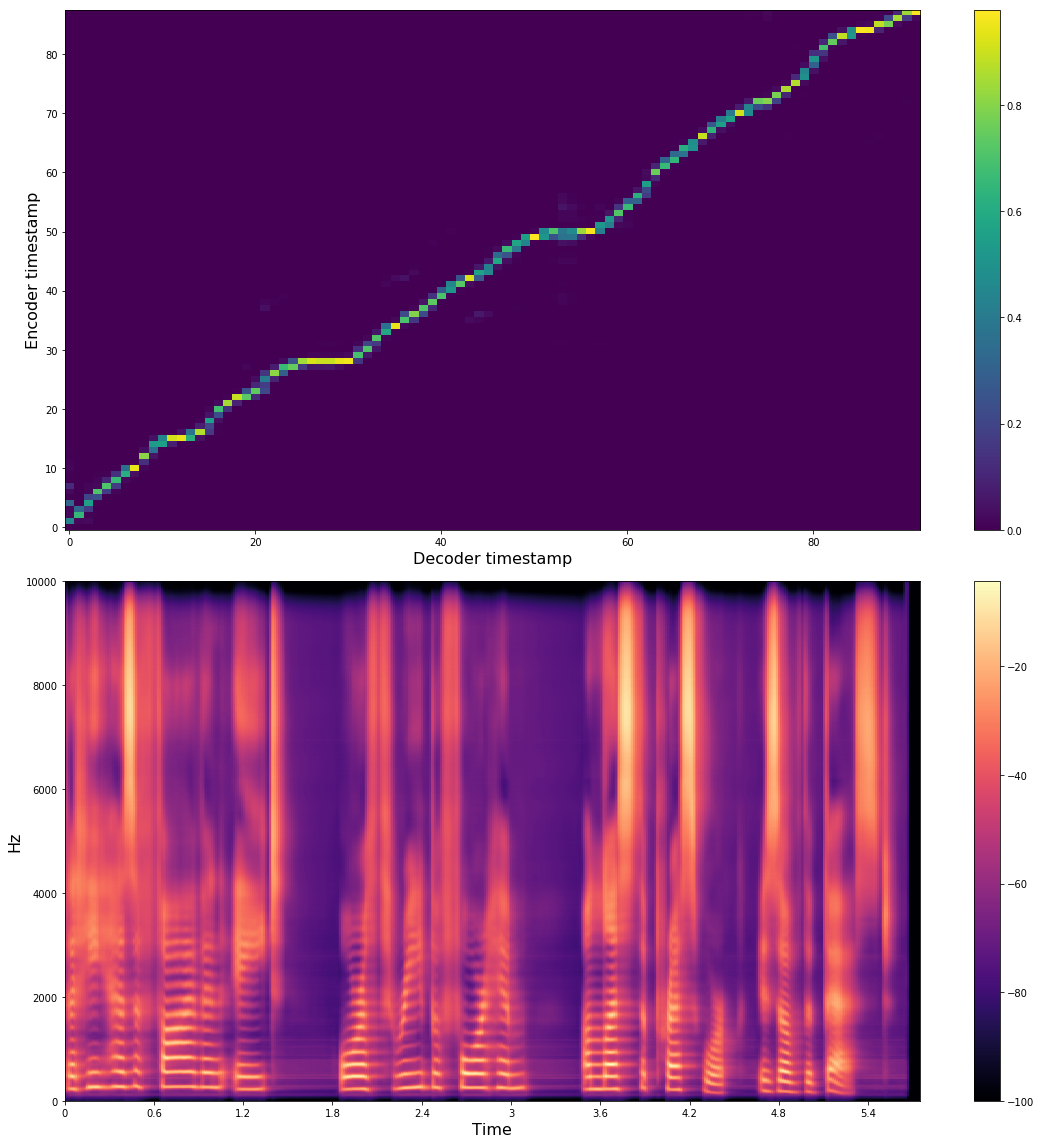

In [6]:
sentence = df.iloc[120, 1].lower().replace(',','')
print(sentence)
align = tts(model, sentence, CONFIG, use_cuda, ap)

### NEW EXAMPLES

/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 1.5912322998046875


/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


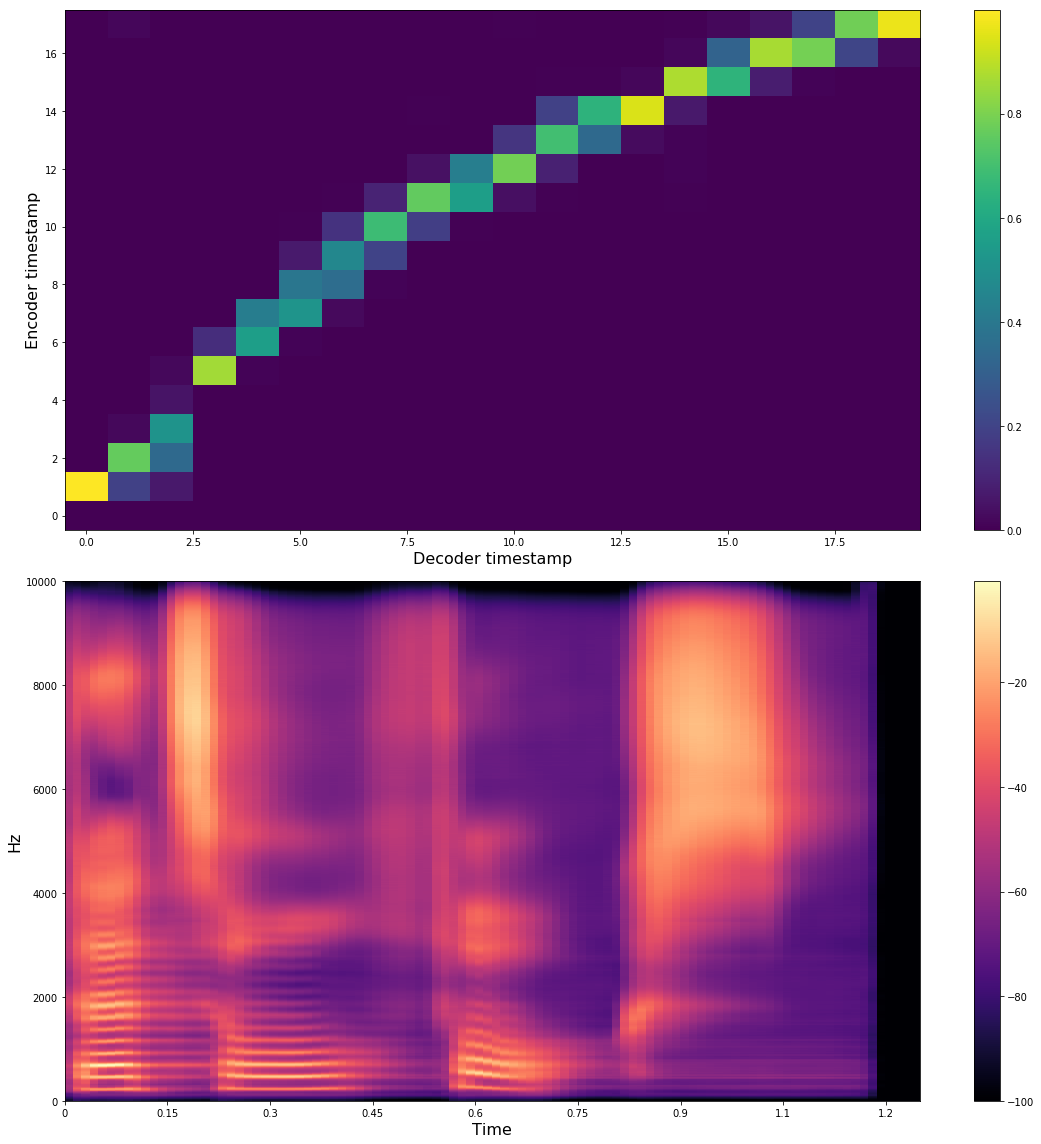

In [10]:
sentence =  "That's all folks."
model.decoder.max_decoder_steps = 300
alignment = tts(model, sentence, CONFIG, use_cuda, ap)